<!-- # Inference with Pretrained LSTM+Attention VGG Binary Sequence Classifier
#
# This notebook demonstrates loading a single CT exam (30 central slices) and running inference
# using a pretrained VGG-16 backbone and LSTM+Attention classifier.
#
# **Setup:**
# - Data directory: `../data/ccccii_selected_nonsegmented`
# - VGG weights: `models/vgg_full_1epochs.pth`
# - LSTM+Attention weights: `models/lstm_attn_vgg_full_2ep.pth` -->


## Inference with Pretrained LSTM+Attention VGG Binary Sequence Classifier

This notebook demonstrates loading a single CT exam (30 central slices) and running inference
using a pretrained VGG-16 backbone and LSTM+Attention classifier.

**Setup:**
- Data directory: `../data/ccccii_selected_nonsegmented`
- VGG weights: `models/vgg_full_1epochs.pth`
- LSTM+Attention weights: `models/lstm_attn_vgg_full_2ep.pth`


In [1]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## 1. Configuration
Set directories and device

In [2]:
DATA_ROOT = '../../data/ccccii_selected_nonsegmented_test'
VGG_WEIGHTS = '../models/vgg_full_1epochs.pth'
LSTM_WEIGHTS = '../models/lstm_attn_vgg_full_2ep.pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")


Using device: cuda


### 1.1. GPU Info

In [3]:

import torch

if DEVICE.type == 'cuda':
    # make sure all kernels have finished
    torch.cuda.synchronize()

    # get device index (or default to current)
    gpu_idx = DEVICE.index if hasattr(DEVICE, 'index') else torch.cuda.current_device()
    props = torch.cuda.get_device_properties(gpu_idx)

    total_mem = props.total_memory / 1e9
    allocated = torch.cuda.memory_allocated() / 1e9
    reserved = torch.cuda.memory_reserved() / 1e9
    peak_alloc = torch.cuda.max_memory_allocated() / 1e9

    print(f"GPU Model:               {props.name}")
    print(f"CUDA Capability:         {props.major}.{props.minor}")
    print(f"Total GPU Memory:        {total_mem:.2f} GB")
    print(f"Currently Allocated:     {allocated:.2f} GB")
    print(f"Currently Reserved:      {reserved:.2f} GB")
    print(f"Peak Allocated Memory:   {peak_alloc:.2f} GB")
else:
    print("CUDA not available. Running on CPU.")


GPU Model:               NVIDIA T550 Laptop GPU
CUDA Capability:         7.5
Total GPU Memory:        4.29 GB
Currently Allocated:     0.00 GB
Currently Reserved:      0.00 GB
Peak Allocated Memory:   0.00 GB


## 2. Dataset Definition
Custom dataset to load central 30 slices of a single exam

In [4]:
class CTSequenceDataset(Dataset):
    def __init__(self, exam_dir, seq_len=30):
        self.seq_len = seq_len
        self.slice_files = sorted(os.listdir(exam_dir))
        total = len(self.slice_files)
        start = max(0, (total - seq_len) // 2)
        end = start + seq_len
        self.files = [os.path.join(exam_dir, f) for f in self.slice_files[start:end]]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        img = Image.open(path).convert('L').resize((512, 512))
        arr = np.array(img).astype(np.float32)
        arr = (arr - arr.mean()) / (arr.std() + 1e-6)
        tensor = torch.tensor(arr).unsqueeze(0)
        return tensor, os.path.basename(path)

## 3. Model Definitions
Load VGG feature extractor and LSTM+Attention classifier

In [5]:
class VGGFeatureExtractor(nn.Module):
    def __init__(self, weights_path):
        super().__init__()
        backbone = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
        emb_dim = backbone.classifier[6].in_features
        backbone.classifier[6] = nn.Identity()
        state = torch.load(weights_path, map_location='cpu')
        backbone.load_state_dict(state, strict=False)
        self.backbone = backbone
        self.embedding_dim = emb_dim

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)
        x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return self.backbone(x)

class LSTMAttentionClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=1, num_classes=2, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attn = nn.Linear(hidden_dim, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        outputs, _ = self.lstm(x)
        weights = torch.softmax(self.attn(outputs).squeeze(-1), dim=1)
        context = (outputs * weights.unsqueeze(-1)).sum(dim=1)
        return self.fc(self.dropout(context)), weights

## 4. Load Models

In [6]:
feat_ext = VGGFeatureExtractor(VGG_WEIGHTS).to(DEVICE).eval()
for p in feat_ext.parameters(): p.requires_grad = False
clf = LSTMAttentionClassifier(input_dim=feat_ext.embedding_dim).to(DEVICE)
clf.load_state_dict(torch.load(LSTM_WEIGHTS, map_location=DEVICE))
clf.eval()
print("Models loaded.")

Models loaded.


## 4.1. Model Summary and Sizes 

In [7]:
## 4.1. Model Summary and Sizes 

# Função para contar parâmetros
def count_params(model):
    return sum(p.numel() for p in model.parameters())

# Contagem de parâmetros
vgg_params = count_params(feat_ext)
lstm_params = count_params(clf)

# Tamanho dos arquivos de pesos
import os
vgg_size_mb = os.path.getsize(VGG_WEIGHTS) / 1e6
lstm_size_mb = os.path.getsize(LSTM_WEIGHTS) / 1e6

# Totais
total_params = vgg_params + lstm_params
total_weights_mb = vgg_size_mb + lstm_size_mb

# Preparar dados para tabela
models_info = [
    ("VGGFeatureExtractor", vgg_params, vgg_params/1e6, vgg_size_mb),
    ("LSTMAttentionClassifier", lstm_params, lstm_params/1e6, lstm_size_mb),
    ("Total", total_params, total_params/1e6, total_weights_mb),
]

# Imprimir tabela formatada
header = f"{'Model':<25} {'Parameters':>15} {'(M params)':>12} {'Weights (MB)':>14}"
print(header)
print("-" * len(header))
for name, params, params_m, size in models_info:
    print(f"{name:<25} {params:>15,} {params_m:>12.2f} {size:>14.2f}")


Model                          Parameters   (M params)   Weights (MB)
---------------------------------------------------------------------
VGGFeatureExtractor           134,268,992       134.27         537.18
LSTMAttentionClassifier         2,164,098         2.16           8.66
Total                         136,433,090       136.43         545.84


## 5. Inference on a Single Exam
Choose one exam directory (Normal or NCP)

In [8]:
# NCP 01
# \\wsl.localhost\Ubuntu\home\paulo\workspace\doutorado\data\ccccii_selected_nonsegmented_test\NCP\100\1338
# exam_path = os.path.join(DATA_ROOT, 'NCP', '100', '1338')

# NCP 02
# \\wsl.localhost\Ubuntu\home\paulo\workspace\doutorado\data\ccccii_selected_nonsegmented_test\NCP\484\2124
exam_path = os.path.join(DATA_ROOT, 'NCP', '484', '2124')

# Normal
# \\wsl.localhost\Ubuntu\home\paulo\workspace\doutorado\data\ccccii_selected_nonsegmented_test\Normal\1708\972
# exam_path = os.path.join(DATA_ROOT, 'Normal', '1708', '972')  

dataset = CTSequenceDataset(exam_path)
dataloader = DataLoader(dataset, batch_size=30, shuffle=False)

# Run inference and visualize attention weights

In [9]:
with torch.no_grad():
    imgs, names = next(iter(dataloader))  # shape [30,1,512,512]
    B, C, H, W = imgs.shape
    imgs = imgs.to(DEVICE)
    flat = imgs.view(B, C, H, W)
    feats = feat_ext(flat)  # [30, emb_dim]
    feats_seq = feats.unsqueeze(0)  # [1,30,emb_dim]
    logits, attn_weights = clf(feats_seq)
    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    pred = np.argmax(probs)
    
    # Map to class names and display percentages
    class_names = ['Normal', 'NCP']
    print(f"Predicted class: {class_names[pred]} ({pred})")
    print("Class probabilities:")
    for cls, p in zip(class_names, probs):
        print(f"  {cls}: {p * 100:.2f}%")

Predicted class: NCP (1)
Class probabilities:
  Normal: 0.05%
  NCP: 99.95%


## 6. Plot Attention Weights

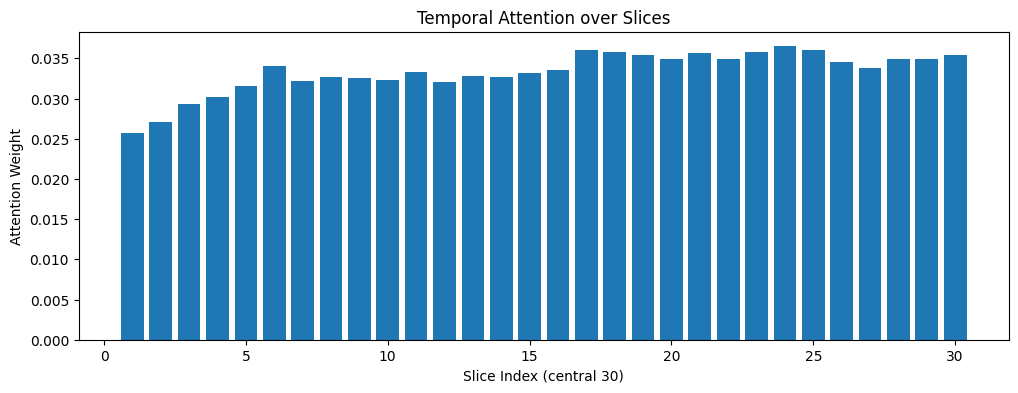

In [10]:
plt.figure(figsize=(12,4))
plt.bar(range(1, B+1), attn_weights.cpu().numpy()[0])
plt.xlabel('Slice Index (central 30)')
plt.ylabel('Attention Weight')
plt.title('Temporal Attention over Slices')
plt.show()

## 7. Slices with Lowest and Highest Attention

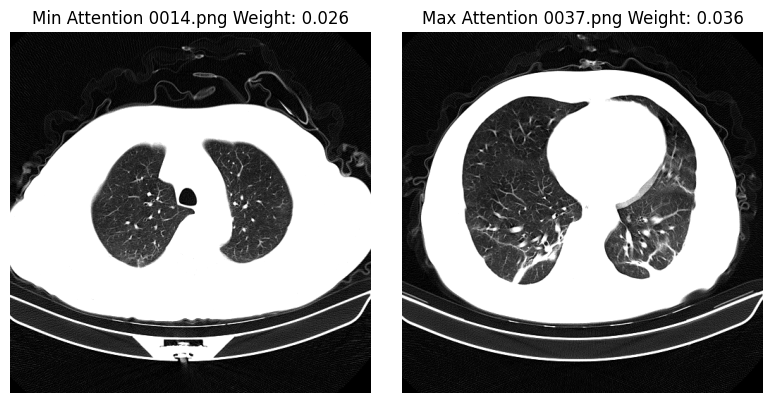

In [11]:
# Identify indices of minimum and maximum attention weights
weights = attn_weights.cpu().numpy()[0]
min_idx = weights.argmin()
max_idx = weights.argmax()

# Convert batch of images back to CPU numpy arrays
images_np = imgs.cpu().numpy()  # shape: [30, 1, 512, 512]

# Plot the two slices with extreme attention
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for ax, idx, label in zip(axes, [min_idx, max_idx], ['Min Attention', 'Max Attention']):
    slice_img = images_np[idx, 0]
    ax.imshow(slice_img, cmap='gray')
    ax.set_title(f"{label} {names[idx]} Weight: {weights[idx]:.3f}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## GPU Info

In [12]:

import torch

if DEVICE.type == 'cuda':
    # make sure all kernels have finished
    torch.cuda.synchronize()

    # get device index (or default to current)
    gpu_idx = DEVICE.index if hasattr(DEVICE, 'index') else torch.cuda.current_device()
    props = torch.cuda.get_device_properties(gpu_idx)

    total_mem = props.total_memory / 1e9
    allocated = torch.cuda.memory_allocated() / 1e9
    reserved = torch.cuda.memory_reserved() / 1e9
    peak_alloc = torch.cuda.max_memory_allocated() / 1e9

    print(f"GPU Model:               {props.name}")
    print(f"CUDA Capability:         {props.major}.{props.minor}")
    print(f"Total GPU Memory:        {total_mem:.2f} GB")
    print(f"Currently Allocated:     {allocated:.2f} GB")
    print(f"Currently Reserved:      {reserved:.2f} GB")
    print(f"Peak Allocated Memory:   {peak_alloc:.2f} GB")
else:
    print("CUDA not available. Running on CPU.")


GPU Model:               NVIDIA T550 Laptop GPU
CUDA Capability:         7.5
Total GPU Memory:        4.29 GB
Currently Allocated:     0.59 GB
Currently Reserved:      3.34 GB
Peak Allocated Memory:   3.22 GB
